In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [3]:
# import data 
df_BVP = pd.read_csv('BVP_pp4.csv', header=None)

In [6]:
n_of_rows = df_BVP.count()
print(n_of_rows)

0    538252
dtype: int64


In [7]:
#actual recording time 57 mins = 3420s
#3420*4=n_rows_keep
n_of_rows_keep = 3420*64
print(n_of_rows_keep)

218880


In [8]:
#using pandas to drop all the rows / seconds after 3420s 
df_BVP = df_BVP.drop(df_BVP.index[218880:538252])

print(df_BVP)

           0
0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
...      ...
218875 -5.49
218876 -6.79
218877 -7.73
218878 -8.37
218879 -8.83

[218880 rows x 1 columns]


In [9]:
#recording is longer than actually is 
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

0    218880
dtype: int64
0    3420.0
dtype: float64
0    57.0
dtype: float64


In [10]:
#create BVP signal 
fsamp = 64  #64 Hz = 0.015625 s(p)
ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')
tstart_df_BVP = 100 #s

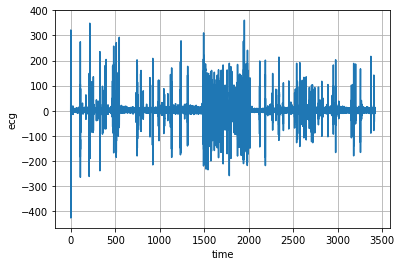

In [11]:
ecg.plot()

In [12]:
ibi = ph.BeatFromECG()(ecg)

In [13]:
ibi.get_duration() #

3420.0

In [14]:
# create label
label = np.zeros(3420)
label[0:600] = 1
label[600:3420] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [15]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [16]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [17]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

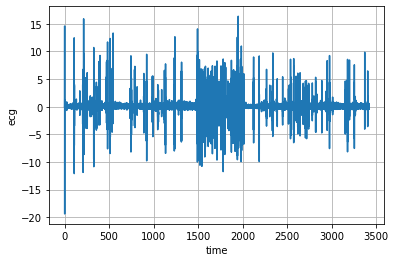

In [18]:
ecg.plot()

In [20]:
ibi = ph.BeatFromECG()(ecg)

In [22]:
ibi.get_duration()

3420.0

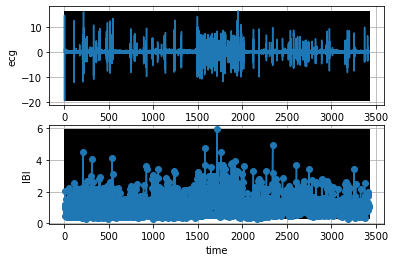

In [23]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [19]:
### physiological indicators 

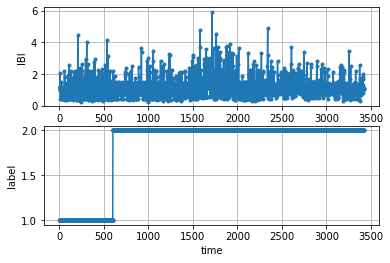

In [24]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()


In [25]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [26]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [27]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1f81f950>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1f2b2310>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1f2b28d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1f81fd50>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1f1bd0d0>,
 'means': []}

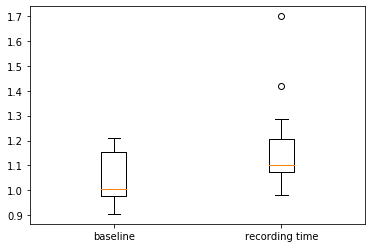

In [28]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['baseline', 'recording time'])

In [29]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [30]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [32]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp4_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp4_df.head()

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.231934,61.231934,1.0,172.329128,517.368341,832.570916,2222.290881
1,61.231934,121.231934,1.0,166.053879,571.061760,797.579106,2222.404715
2,121.231934,181.231934,1.0,195.340190,449.959096,924.516545,2317.339360
3,181.231934,241.231934,1.0,382.923938,740.336090,867.147253,2686.296053
4,241.231934,301.231934,1.0,272.811671,432.771252,748.751005,2122.220770


In [33]:
#save data 
FD_HRV_pp4_df.to_csv('FD_HRV_pp4.csv')